In [21]:
import pandas as pd
import seaborn as see
from matplotlib import pyplot as plt
import sys
from dateutil import parser
import openpyxl as op
print(sys.version)
print('pandas version', pd.__version__)



3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
pandas version 2.2.3


# Preparing data


In [22]:
excel_file = 'logio.xlsx'
df_ciselniky = pd.read_excel(excel_file, sheet_name='ciselniky',usecols='G:H', skiprows=1)
df_kusovnik = pd.read_excel(excel_file, sheet_name='matice_vyroby')
df_ciselniky.head()

,ID_komponenty,Porizovaci_cena
0,KO001,11600
1,KO002,2550
2,KO003,13300
3,KO004,2350
4,KO005,14950


In [23]:
# extracting manufacturing data from csv_excel file
wb = op.load_workbook(excel_file)
sheet = wb['vyroba_text']

def get_csv_data(sheet):
	csv_data = []
	for row in sheet.iter_rows(values_only=True):
		row_list = []
		for element in row[0].split(';'):
			row_list.append(element)
		csv_data.append(row_list)
	return csv_data

def date_parser(date_string):
    try:
        return parser.parse(date_string, dayfirst=True)
    except ValueError:
        raise Exception("We still have a problem")



#creating data frame
csv_data = get_csv_data(sheet)
df_vyroba = pd.DataFrame(csv_data[1:], columns=csv_data[0])
# Converting datatypes (daful is object)
df_vyroba['Datum'] = df_vyroba['Datum'].apply(date_parser)
df_vyroba['Mnozstvi'] = pd.to_numeric(df_vyroba['Mnozstvi'],).astype('Int64')
# Adding colum 'mesic;
df_vyroba['Mesic'] = df_vyroba['Datum'].dt.month
df_vyroba['Rok'] = df_vyroba['Datum'].dt.year
df_vyroba['Rok-Mesic'] = df_vyroba['Datum'].dt.strftime('%Y-%m')

df_vyroba.info()
df_vyroba.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2158 entries, 0 to 2157
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID_sortimentu  2158 non-null   object        
 1   ID_zavodu      2158 non-null   object        
 2   Datum          2158 non-null   datetime64[ns]
 3   Mnozstvi       2158 non-null   Int64         
 4   Mesic          2158 non-null   int32         
 5   Rok            2158 non-null   int32         
 6   Rok-Mesic      2158 non-null   object        
dtypes: Int64(1), datetime64[ns](1), int32(2), object(3)
memory usage: 103.4+ KB


,ID_sortimentu,ID_zavodu,Datum,Mnozstvi,Mesic,Rok,Rok-Mesic
0,ND102,ZP30,2017-03-03,25,3,2017,2017-03
1,ND123,ZP10,2018-05-14,16,5,2018,2018-05
2,ND112,ZP30,2017-02-10,29,2,2017,2017-02
3,ND118,ZP20,2018-08-08,1,8,2018,2018-08
4,ND119,ZP20,2018-01-14,16,1,2018,2018-01


In [24]:
# zpozdene dodavky:
df_dodavky = pd.read_excel(excel_file, sheet_name='dodavky')
df_dodavky['Zpozdeno'] = (df_dodavky['Datum_dodani'] - df_dodavky['Datum_objednani']).dt.days.apply(lambda x: x > 7)
df_dodavky['Deadline'] = (df_dodavky['Datum_objednani'] + pd.Timedelta(days=7))
df_dodavky.shape
df_dodavky.sample(10)

,ID_dodavatele,ID_skladu,ID_komponenty,Mnozstvi,Datum_objednani,Datum_dodani,Zpozdeno,Deadline
618,47EFKT,SK00,KO174,12,2018-04-03,2018-04-07,False,2018-04-10
265,999DJT8,SK00,KO050,1,2018-05-10,2018-05-14,False,2018-05-17
848,102ADF,SK02,KO069,13,2018-04-02,2018-04-05,False,2018-04-09
1224,102ADF,SK00,KO064,19,2017-12-02,2017-12-08,False,2017-12-09
288,25KOL9,SK02,KO174,11,2017-08-25,2017-08-30,False,2017-09-01
2046,25KOL9,SK56,KO134,8,2018-04-20,2018-05-02,True,2018-04-27
312,47EFKT,SK00,KO019,13,2018-06-11,2018-06-18,False,2018-06-18
1846,102ADF,SK97,KO024,13,2017-09-01,2017-09-04,False,2017-09-08
600,102ADF,SK01,KO042,16,2017-05-26,2017-05-29,False,2017-06-02
1306,47EFKT,SK56,KO046,20,2018-07-24,2018-07-30,False,2018-07-31


# 1. uloha
- merge --> group by --> sum pro vypocet celkovych nakladu na produkt

In [25]:
df_ciselniky.head()

,ID_komponenty,Porizovaci_cena
0,KO001,11600
1,KO002,2550
2,KO003,13300
3,KO004,2350
4,KO005,14950


In [26]:
df_kusovnik.head()

,ID_produktu,ID_komponenty,Mnozstvi
0,ND101,KO043,2
1,ND101,KO124,1
2,ND101,KO193,3
3,ND101,KO120,1
4,ND102,KO160,1


In [27]:
df_merged = pd.merge(df_kusovnik, df_ciselniky, on='ID_komponenty', how='left')
df_merged['celkova_cena_komponenty'] = df_merged['Mnozstvi'] * df_merged['Porizovaci_cena']
df_merged.info()
df_merged.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID_produktu              77 non-null     object
 1   ID_komponenty            77 non-null     object
 2   Mnozstvi                 77 non-null     int64 
 3   Porizovaci_cena          77 non-null     int64 
 4   celkova_cena_komponenty  77 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 3.1+ KB


(77, 5)

### ID_produktu  a jeho celkové náklady:

In [28]:
df_total_price = df_merged.groupby('ID_produktu')['celkova_cena_komponenty'].sum().reset_index()
df_total_price.sort_values(by='celkova_cena_komponenty', ascending=False)

,ID_produktu,celkova_cena_komponenty
10,ND111,79950
18,ND119,74550
21,ND122,73100
6,ND107,65400
8,ND109,64800
5,ND106,64050
14,ND115,63750
13,ND114,58650
19,ND120,57250
2,ND103,52650


# 2. uloha: vyvoj vyroby za posledni rok po mesicich v jednotlivych zavodech

In [29]:
# Celkovy pocet produktu vyrobenych zavodem v dany mesic
df_vyroba_mesice_zavody = df_vyroba.groupby(['ID_zavodu', 'Rok', 'Rok-Mesic', 'Mesic'])['Mnozstvi'].sum().reset_index()
# Celkovy pocet produktu daneho typu vyrobenych zavodem v dany mesic
df_vyroba_mesice= df_vyroba.groupby(['ID_zavodu', 'ID_sortimentu', 'Rok', 'Mesic', 'Rok-Mesic'])['Mnozstvi'].sum().reset_index()
df_vyroba_mesice.info()
df_vyroba_mesice_zavody.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID_zavodu      1129 non-null   object
 1   ID_sortimentu  1129 non-null   object
 2   Rok            1129 non-null   int32 
 3   Mesic          1129 non-null   int32 
 4   Rok-Mesic      1129 non-null   object
 5   Mnozstvi       1129 non-null   Int64 
dtypes: Int64(1), int32(2), object(3)
memory usage: 45.3+ KB


,ID_zavodu,Rok,Rok-Mesic,Mesic,Mnozstvi
0,ZP10,2017,2017-01,1,518
1,ZP10,2017,2017-02,2,600
2,ZP10,2017,2017-03,3,751
3,ZP10,2017,2017-04,4,454
4,ZP10,2017,2017-05,5,826


## Celkova vyroba po mesicich

Text(0.5, 0, 'Datum [rok-měsíc]')

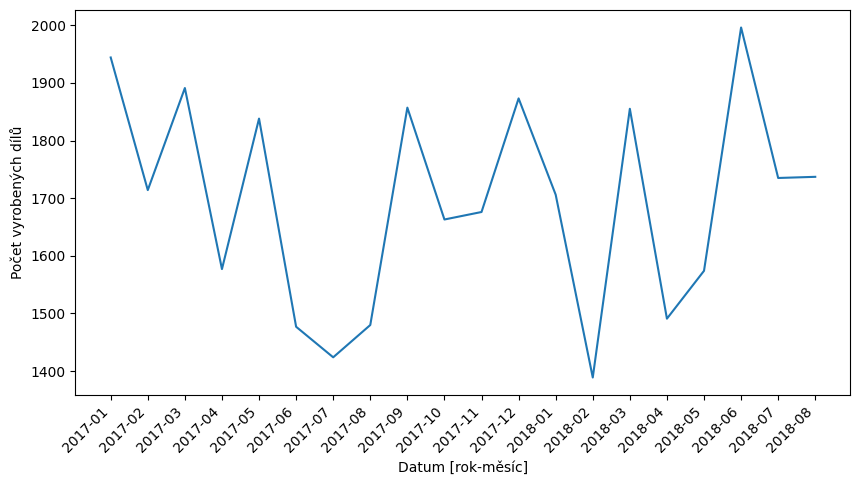

In [30]:
fig1 = see.lineplot(data = df_vyroba.groupby('Rok-Mesic')['Mnozstvi'].sum().reset_index(),
					 x='Rok-Mesic', y = 'Mnozstvi')
fig1.figure.set_size_inches(10,5)
#fig1.set_xticklabels(rotation=45, ha='right')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Počet vyrobených dílů')
plt.xlabel('Datum [rok-měsíc]')

# Celkova vyrovba po mesicich - zavody

Text(0.5, 0, 'Datum [rok-měsíc]')

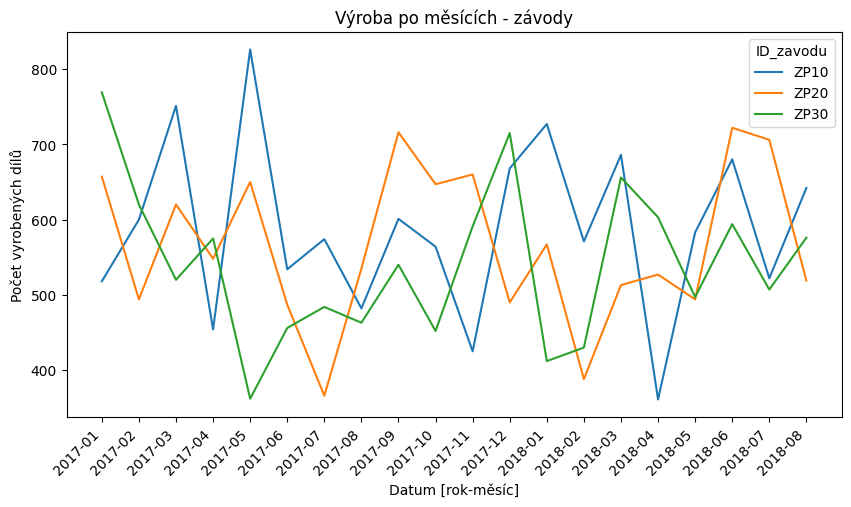

In [31]:
#see.set_context("notebook", font_scale=0.7)
roky = (2017,2019)
palette = see.color_palette("hls", 6)

fig1 = see.lineplot(data=df_vyroba_mesice_zavody.query("(Rok >= @roky[0]) & (Rok <= @roky[1])"), x='Rok-Mesic', y = 'Mnozstvi', hue = "ID_zavodu")
fig1.figure.set_size_inches(10,5)
#fig1.set_xticklabels(rotation=45, ha='right')
plt.title('Výroba po měsících - závody')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Počet vyrobených dílů')
plt.xlabel('Datum [rok-měsíc]')

__Sloupcový graf pro jednotlivý závod. Je třeba zadat ID závodu do proměnné zavod__

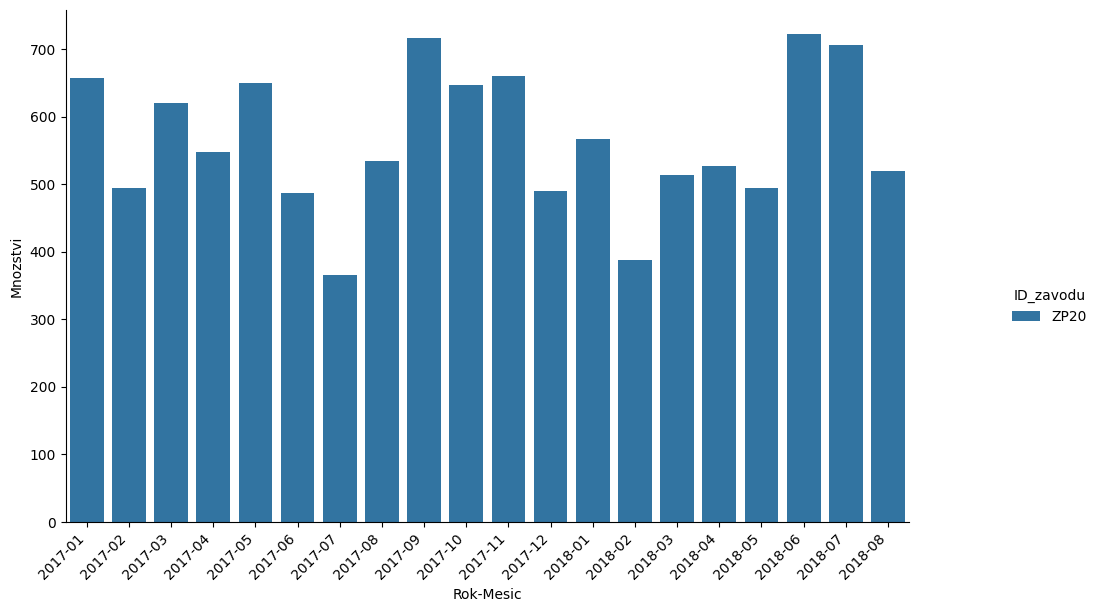

In [32]:

roky = (2016,2019)
zavod = 'ZP20'

fig1 = see.catplot(data=df_vyroba_mesice_zavody.query("(Rok >= @roky[0]) & (Rok <= @roky[1]) & (ID_zavodu == @zavod)"), x='Rok-Mesic', y = 'Mnozstvi', hue = "ID_zavodu",kind='bar' )
fig1.figure.set_size_inches(12,6)
fig1.set_xticklabels(rotation=45, ha='right')

# 3. Úloha dodávky se zpožděním


In [33]:
df_dodavky['Dodaci_doba'] = df_dodavky['Datum_dodani'] - df_dodavky['Datum_objednani']
df_dodavky_zpozdene = df_dodavky.query('Zpozdeno == True')
print(f"Casove obdobi: {df_dodavky['Datum_objednani'].min()} {df_dodavky['Datum_objednani'].max()}")
print("Celkovy pocet dodavek v datasetu: ", len(df_dodavky))
print("Celkovy pocet zpozdenych dodavek v datasetu: ", len(df_dodavky_zpozdene))
print("% zpozdenych dodavek: ", (1 - (len(df_dodavky) - len(df_dodavky_zpozdene)) / len(df_dodavky)) * 100)

Casove obdobi: 2017-01-01 00:00:00 2018-08-31 00:00:00
Celkovy pocet dodavek v datasetu:  2058
Celkovy pocet zpozdenych dodavek v datasetu:  239
% zpozdenych dodavek:  11.613216715257535


In [34]:
df_dodavky_zpozdene

,ID_dodavatele,ID_skladu,ID_komponenty,Mnozstvi,Datum_objednani,Datum_dodani,Zpozdeno,Deadline,Dodaci_doba
6,25KOL9,SK97,KO049,1,2018-03-29,2018-04-11,True,2018-04-05,13 days
10,47EFKT,SK56,KO044,15,2017-02-28,2017-03-10,True,2017-03-07,10 days
21,25KOL9,SK56,KO142,2,2018-06-08,2018-06-16,True,2018-06-15,8 days
27,47EFKT,SK56,KO070,18,2017-07-17,2017-07-26,True,2017-07-24,9 days
41,25KOL9,SK11,KO204,2,2017-06-01,2017-06-13,True,2017-06-08,12 days
...,...,...,...,...,...,...,...,...,...
2038,999DJT8,SK97,KO177,6,2017-02-19,2017-03-06,True,2017-02-26,15 days
2041,47EFKT,SK86A,KO069,5,2017-04-20,2017-05-01,True,2017-04-27,11 days
2046,25KOL9,SK56,KO134,8,2018-04-20,2018-05-02,True,2018-04-27,12 days
2048,25KOL9,SK01,KO172,16,2017-05-30,2017-06-09,True,2017-06-06,10 days


## Pocet dodavek od kazdeho dodavatele

In [35]:
df_dodavky.groupby('ID_dodavatele')['ID_komponenty'].count().reset_index(name='Pocet_objednavek')

,ID_dodavatele,Pocet_objednavek
0,102ADF,527
1,25KOL9,535
2,47EFKT,509
3,999DJT8,487


## pocet zpozdenych dodavek od dodavatele

In [36]:
df_dodavky_zpozdene.groupby('ID_dodavatele').size().reset_index(name= 'Pocet_zpozdenych_objednavek')
#df_dodavky_zpozdene.groupby('ID_dodavatele')['ID_komponenty'].count().reset_index()

,ID_dodavatele,Pocet_zpozdenych_objednavek
0,102ADF,60
1,25KOL9,64
2,47EFKT,64
3,999DJT8,51


## Mnozstvi nahradnich dilu od kazdeho dodavatele

In [37]:
df_dodavky.groupby('ID_dodavatele')['Mnozstvi'].sum().reset_index(name='Celkove_mnozstvi')

,ID_dodavatele,Celkove_mnozstvi
0,102ADF,5698
1,25KOL9,5527
2,47EFKT,5325
3,999DJT8,4955


## Průměrná délka zpožděných objednávek na celku

In [38]:
print(df_dodavky_zpozdene['Dodaci_doba'].mean())
print(f"Prumerna doba zpozdeni: {df_dodavky_zpozdene['Dodaci_doba'].mean().days} days {df_dodavky_zpozdene['Dodaci_doba'].mean().components.hours} hours {df_dodavky_zpozdene['Dodaci_doba'].mean().components.minutes} minutes")

11 days 11:32:53.221757322
Prumerna doba zpozdeni: 11 days 11 hours 32 minutes


In [39]:
df_dodavky_zpozdene['Dodaci_doba'].describe()


count                           239
mean     11 days 11:32:53.221757322
std       2 days 06:41:08.251690338
min                 8 days 00:00:00
25%                10 days 00:00:00
50%                11 days 00:00:00
75%                13 days 00:00:00
max                15 days 00:00:00
Name: Dodaci_doba, dtype: object

## Průměrná délka zpoždění u zpožděných objednávek

In [40]:
df_neco = df_dodavky_zpozdene['Dodaci_doba'] - (df_dodavky_zpozdene['Deadline'] - df_dodavky_zpozdene['Datum_objednani'])
df_neco.mean()
print(f"Průměrná délka zpoždění u zpožděných objednávek: {df_neco.mean()}")
print(f"Směrodatná odchylka zpoždění u zpožděných objednávek: {df_neco.std()}")
df_neco.describe()


Průměrná délka zpoždění u zpožděných objednávek: 4 days 11:32:53.221757322
Směrodatná odchylka zpoždění u zpožděných objednávek: 2 days 06:41:08.251690338


count                          239
mean     4 days 11:32:53.221757322
std      2 days 06:41:08.251690338
min                1 days 00:00:00
25%                3 days 00:00:00
50%                4 days 00:00:00
75%                6 days 00:00:00
max                8 days 00:00:00
dtype: object